In [27]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# ***`Libraries`***

In [28]:
import pandas as pd
import re
import json
import ast
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx


# ***`Read Data`***

In [29]:
file_path = '/content/drive/My Drive/Colab Notebooks/SocialNetworkingCourse/Project VNexpress/vnexpress_articles_4.xlsx'
df = pd.read_excel(file_path)

In [30]:
def clean_date(date_str):
    # Lấy phần ngày tháng năm (loại bỏ các ký tự không cần thiết)
    date_part = date_str.split(",")[1].strip()
    # Chuyển đổi chuỗi thành định dạng datetime
    date_obj = pd.to_datetime(date_part, format='%d/%m/%Y')
    # Định dạng lại chuỗi ngày
    return date_obj.strftime('%A, %d/%m/%Y')
df['Formatted_Date'] = df['Date'].apply(clean_date)


In [31]:
df = df.drop(columns=['Date', 'Detailed Title', 'Comments Count', 'Content', 'Link'])
df.head(5)

,Title,Author,Author Link,Category,Description,Comments,Formatted_Date
0,Tam giác mục tiêu 2025,Cấn Văn Lực,https://vnexpress.net/tac-gia/can-van-luc-998....,Kinh doanh & quản trị,Chuyên gia kinh tế,"[{'Nickname': 'dinhquang3082003', 'Nickname Li...","Wednesday, 01/01/2025"
1,Động lực kinh tế tư nhân,Nguyễn Hoa Cương,https://vnexpress.net/tac-gia/nguyen-hoa-cuong...,Kinh doanh & quản trị,Chuyên gia kinh tế,"[{'Nickname': 'Nhật Nhật Tân.', 'Nickname Link...","Wednesday, 01/01/2025"
2,Miễn học phí ngành Y?,Nguyễn Minh Hoàng,https://vnexpress.net/tac-gia/nguyen-minh-hoan...,Giáo dục & tri thức,Nhà công tác xã hội và phát triển cộng đồng,"[{'Nickname': 'Khánh Super', 'Nickname Link': ...","Tuesday, 31/12/2024"
3,Đến Việt Nam chữa bệnh,Nguyễn Hồng Hà,https://vnexpress.net/tac-gia/nguyen-hong-ha-1...,Y tế & sức khỏe,Bác sĩ phẫu thuật,"[{'Nickname': 'hanhantramchuong', 'Nickname Li...","Monday, 30/12/2024"
4,'Ăn cắp' thời công nghệ,Quan Thế Dân,https://vnexpress.net/tac-gia/quan-the-dan-144...,Văn hóa & lối sống,"Bác sĩ, Tiến sĩ Y học","[{'Nickname': 'thecong85', 'Nickname Link': 'h...","Sunday, 29/12/2024"


In [32]:
# Function to process Comments_Post
def extract_comments_info(comments):
    result = []
    # Check if 'comments' is a string and attempt to convert to a list of dictionaries
    if isinstance(comments, str):
        try:
            comments = ast.literal_eval(comments)  # Safely evaluate the string
        except (SyntaxError, ValueError):
            # Handle cases where conversion fails (e.g., invalid JSON)
            return result  # Return empty result if conversion fails

    # Now proceed with the original logic if 'comments' is a list of dictionaries
    for comment in comments:
        if isinstance(comment, dict):  # Ensure comment is a dictionary
            result.append({
                "Nickname": comment.get("Nickname", ""),
                "Nickname Link": comment.get("Nickname Link", ""),
                "Reply Nicknames": comment.get("Reply Nicknames", []),
                "Reply Links": comment.get("Reply Links", [])
            })
    return result

# Apply extraction to the Comments_Post column
df['Processed_Comments'] = df['Comments'].apply(extract_comments_info)

# Drop the original Comments_Post column for cleaner display
df.drop(columns=['Comments'], inplace=True)

In [33]:
# Extract Author ID from Author Link (keep full ID including numbers)
df["Author Link"] = df["Author Link"].str.extract(r".*/(.*)\.html")

# Extract Processed_Comments into structured form
def process_comments(comments):
    processed = []
    for comment in comments:
        nickname_link = comment.get("Nickname Link", "")
        reply_links = comment.get("Reply Links", [])
        # Extract IDs
        nickname_id = nickname_link.split("/")[-1] if nickname_link else ""
        reply_ids = [link.split("/")[-1] for link in reply_links]
        processed.append({
            "Nickname ID": nickname_id,
            "Reply IDs": reply_ids,
        })
    return processed

df["Processed_Comments"] = df["Processed_Comments"].apply(process_comments)


df = df.drop(columns = ['Title', 'Author', "Formatted_Date"])
# Display the result
df.head(2)

,Author Link,Category,Description,Processed_Comments
0,can-van-luc-998,Kinh doanh & quản trị,Chuyên gia kinh tế,"[{'Nickname ID': '1080039082', 'Reply IDs': []..."
1,nguyen-hoa-cuong-1336,Kinh doanh & quản trị,Chuyên gia kinh tế,"[{'Nickname ID': '1002685738', 'Reply IDs': []}]"


In [34]:
G = nx.DiGraph()

In [35]:
# Thêm tác giả vào đồ thị
author_id = df["Author Link"].iloc[0]  # Get the first author ID in the Series
G.add_node(author_id, role="author")

# Thêm các người bình luận và kết nối họ với tác giả
for comments_list in df["Processed_Comments"]:  # Iterate through the list of comments for each row
    for comment in comments_list:  # Iterate through individual comments in the list
        nickname_id = comment["Nickname ID"]
        replies = comment["Reply IDs"]

        # Thêm người bình luận
        G.add_node(nickname_id, role="commenter")

        # Kết nối người bình luận với tác giả
        G.add_edge(nickname_id, author_id, relationship="commented_on")

        # Thêm kết nối với người được trả lời
        for reply_id in replies:
            G.add_node(reply_id, role="commenter")
            G.add_edge(reply_id, nickname_id, relationship="replied_to")

In [36]:
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
print(f"Number of Nodes: {num_nodes}")
print(f"Number of Edges: {num_edges}")

Number of Nodes: 17105
Number of Edges: 28086


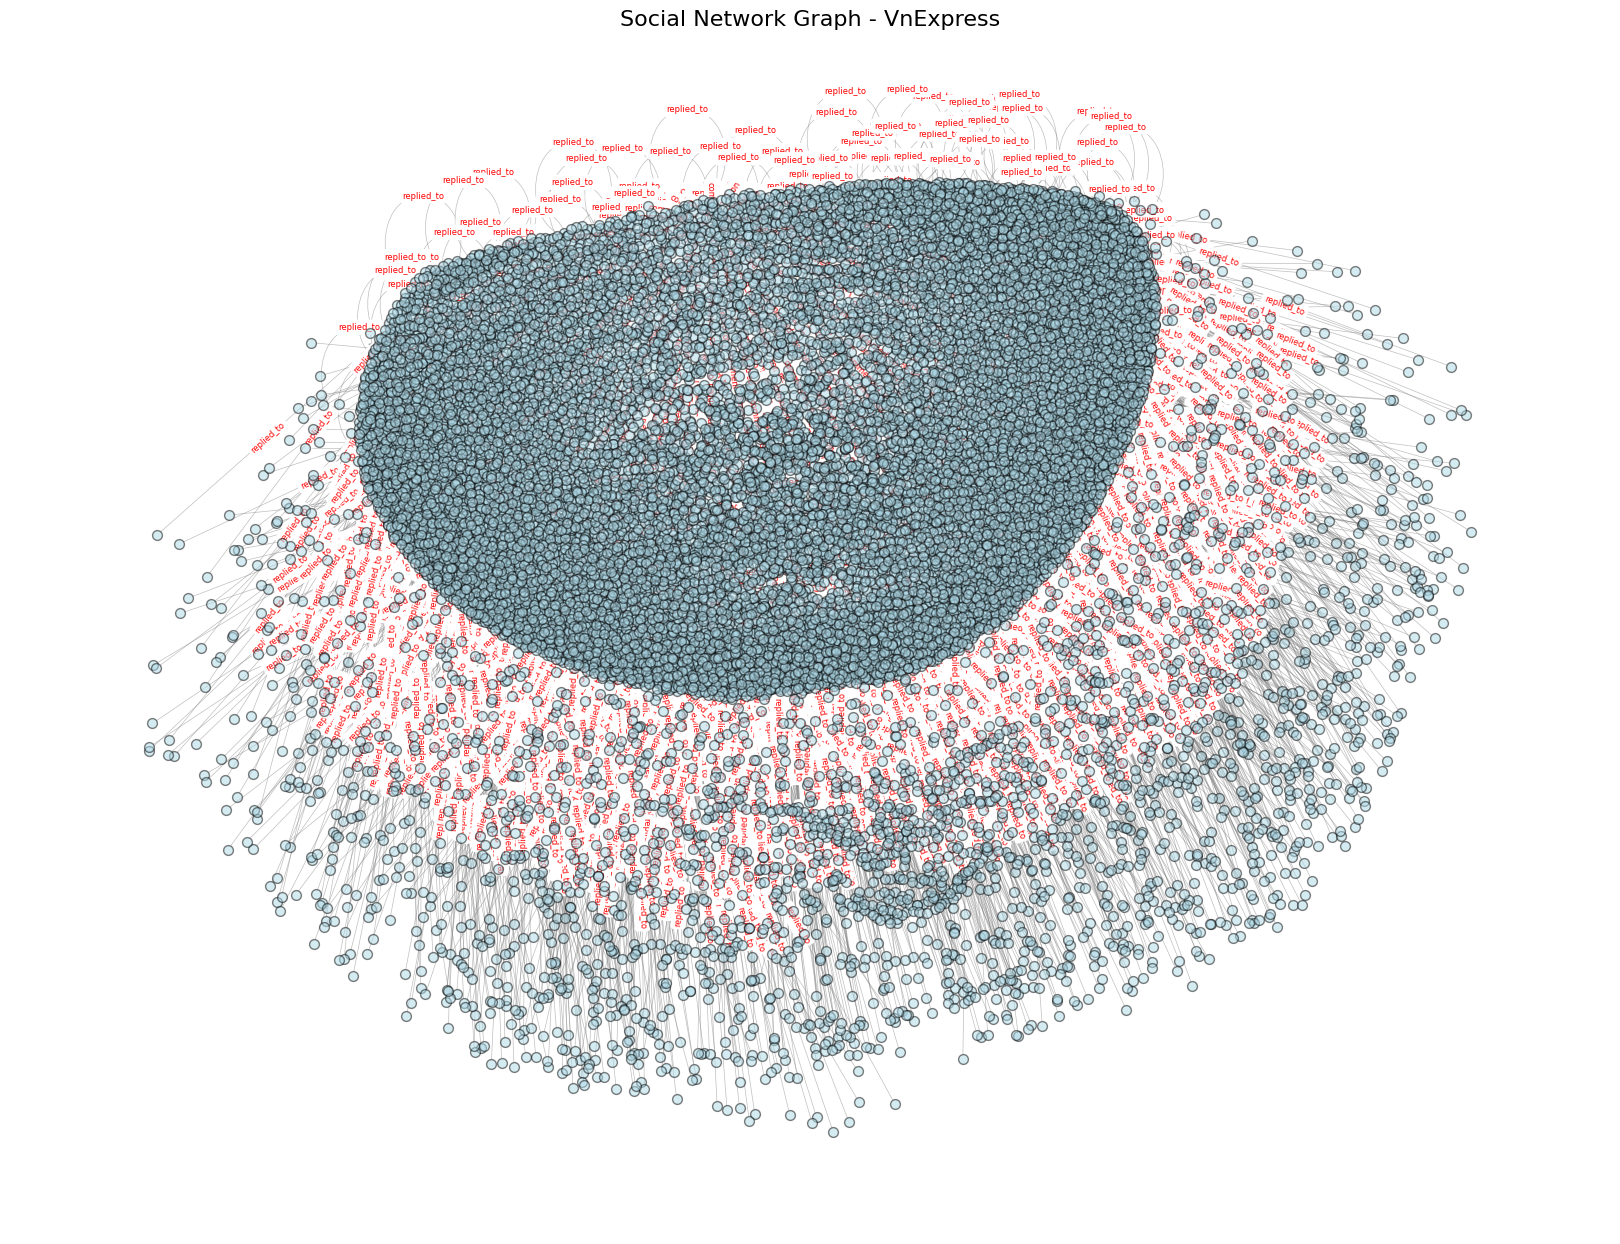

In [37]:
# Vẽ đồ thị với kích thước và các thông số tối ưu hóa
plt.figure(figsize=(16, 12))  # Kích thước đồ thị lớn hơn

# Điều chỉnh layout với tham số k nhỏ hơn để giảm độ chồng chéo của các node
pos = nx.spring_layout(G, seed=42, k=0.05, iterations=50)  # Giảm k để nới rộng các node

# Lấy mối quan hệ giữa các node
edge_labels = nx.get_edge_attributes(G, "relationship")

# Vẽ đồ thị
nx.draw(
    G,
    pos,
    with_labels=False,  # Không hiển thị nhãn cho tất cả nodes để tránh quá tải
    node_size=50,  # Giảm kích thước nodes
    font_size=8,  # Giảm kích thước font chữ
    font_color="black",
    edge_color="gray",
    width=0.5,  # Giảm độ dày của các cạnh
    alpha=0.5,  # Độ mờ của các cạnh
    node_color="lightblue",
    edgecolors="black"
)

# Hiển thị tên mối quan hệ trên các cạnh (nếu cần)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="red", font_size=6)

# Tiêu đề đồ thị
plt.title("Social Network Graph - VnExpress", fontsize=16)
plt.show()


In [40]:
# Export the graph to a file in GraphML format
output_file = "/content/drive/My Drive/Colab Notebooks/SocialNetworkingCourse/Project VNexpress/social_network.graphml"
nx.write_graphml(G, output_file)

output_file


'/content/drive/My Drive/Colab Notebooks/SocialNetworkingCourse/Project VNexpress/social_network.graphml'